In [1]:
#tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'


In [3]:
print(hist)


                high       low      open  volumefrom    volumeto     close  \
time                                                                         
2020-12-08  24707.49  23425.28  24626.17      102.86  2479400.96  23626.47   
2020-12-09  23982.97  22764.23  23626.47      145.18  3417104.26  23932.51   
2020-12-10  23932.51  22812.36  23932.51      138.09  3238904.37  23355.09   
2020-12-11  23396.16  22588.52  23355.09       79.81  1830605.31  23081.68   
2020-12-12  24281.12  23081.68  23081.68       40.93   973072.53  24155.59   
...              ...       ...       ...         ...         ...       ...   
2022-04-18  51662.93  48601.04  49966.46       64.73  3232703.51  51284.40   
2022-04-19  52508.03  50856.11  51284.40       80.09  4136822.73  52224.65   
2022-04-20  52784.10  51120.99  52224.65       65.68  3410542.93  51679.82   
2022-04-21  53578.29  50081.09  51679.82      108.57  5651787.23  50956.68   
2022-04-22  51381.47  50710.33  50956.68       31.09  1588420.16

In [4]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [5]:
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-12-08,24707.49,23425.28,24626.17,102.86,2479400.96,23626.47
2020-12-09,23982.97,22764.23,23626.47,145.18,3417104.26,23932.51
2020-12-10,23932.51,22812.36,23932.51,138.09,3238904.37,23355.09
2020-12-11,23396.16,22588.52,23355.09,79.81,1830605.31,23081.68
2020-12-12,24281.12,23081.68,23081.68,40.93,973072.53,24155.59
...,...,...,...,...,...,...
2022-04-18,51662.93,48601.04,49966.46,64.73,3232703.51,51284.40
2022-04-19,52508.03,50856.11,51284.40,80.09,4136822.73,52224.65
2022-04-20,52784.10,51120.99,52224.65,65.68,3410542.93,51679.82


In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(hist, test_size=0.2)

In [8]:
train

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-12-08,24707.49,23425.28,24626.17,102.86,2479400.96,23626.47
2020-12-09,23982.97,22764.23,23626.47,145.18,3417104.26,23932.51
2020-12-10,23932.51,22812.36,23932.51,138.09,3238904.37,23355.09
2020-12-11,23396.16,22588.52,23355.09,79.81,1830605.31,23081.68
2020-12-12,24281.12,23081.68,23081.68,40.93,973072.53,24155.59
...,...,...,...,...,...,...
2022-01-08,53306.71,50928.89,52455.50,78.60,4096787.58,52481.24
2022-01-09,53553.83,51604.65,52481.24,61.74,3237479.61,52683.40
2022-01-10,53163.92,50048.73,52683.40,101.34,5287369.14,52835.75


In [9]:
test

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-01-13,55393.87,52902.79,54975.38,55.65,3010472.71,53220.50
2022-01-14,54495.61,52296.47,53220.50,45.39,2432183.00,54098.95
2022-01-15,54946.80,53484.10,54098.95,22.50,1219528.13,54164.62
2022-01-16,54665.77,51808.75,54258.74,764.94,41432379.49,54164.22
2022-01-17,54169.58,52061.94,54088.55,39.97,2122868.43,52879.21
...,...,...,...,...,...,...
2022-04-18,51662.93,48601.04,49966.46,64.73,3232703.51,51284.40
2022-04-19,52508.03,50856.11,51284.40,80.09,4136822.73,52224.65
2022-04-20,52784.10,51120.99,52224.65,65.68,3410542.93,51679.82


In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

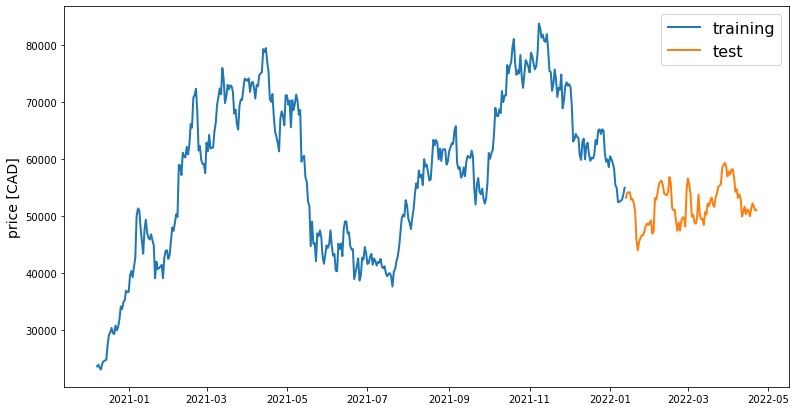

In [11]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [12]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [13]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [14]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [15]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [32]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 25
batch_size = 36
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [33]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [38]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
print(type(model))
print(type(history))
print(type(history.history))

Epoch 1/25
11/11 [==============================] - 2s 45ms/step - loss: 0.0113 - val_loss: 0.0043
Epoch 2/25
11/11 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 3/25
11/11 [==============================] - 0s 10ms/step - loss: 0.0087 - val_loss: 0.0095
Epoch 4/25
11/11 [==============================] - 0s 9ms/step - loss: 0.0127 - val_loss: 0.0062
Epoch 5/25
11/11 [==============================] - 0s 10ms/step - loss: 0.0098 - val_loss: 0.0036
Epoch 6/25
11/11 [==============================] - 0s 9ms/step - loss: 0.0077 - val_loss: 0.0041
Epoch 7/25
11/11 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 8/25
11/11 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 9/25
11/11 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 10/25
11/11 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 11/25
1

In [40]:
print(history)

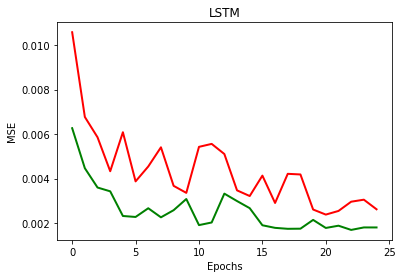

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [43]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)
print(type(targets))
print(type(preds))
mean_absolute_error(preds, y_test)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


0.030743581108972236

In [44]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0017799248907505625

In [45]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6697532457688249

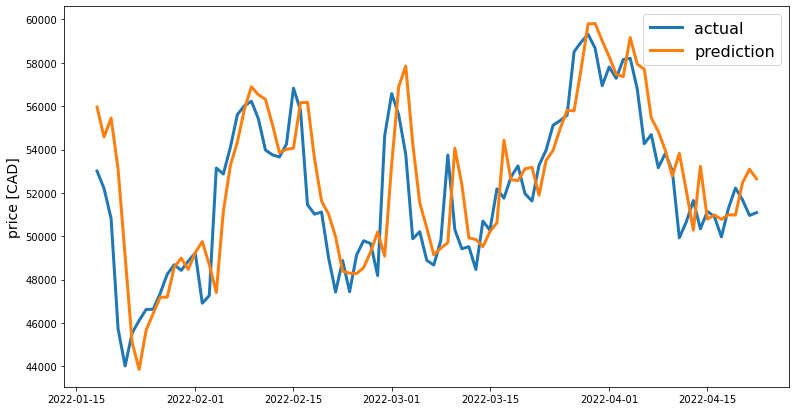

In [46]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)